In [1]:
using Pkg

using DifferentialEquations, Plots
using LinearAlgebra
using Random


In [2]:
function FN3_run(;
    eps=0.02, Vshift=-0.2, alpha=1.0, beta=0.01,  # Cellular parameters
    gsyn12=0.02, gsyn23=0.02, gsyn31=0.02, Erev=-2.0,  # Synaptic parameters
    Iext=-0.01, t1=600.0, t2=650.0, IC_shift=0,  # Stimulus parameters
    tmax=2000.0, step=0.2)  # Time settings

    # Define the system of equations
    function fhn_3cells!(du, u, p, t)
        V1, V2, V3, Ca1, Ca2, Ca3, s1, s2, s3 = u
        eps, Vshift, alpha, beta, gsyn12, gsyn23, gsyn31, Erev = p

        # Apply external stimulus
        Iapp = (t1 < t < t2) ? Iext : 0.0

        # FitzHugh-Nagumo equations with synaptic coupling
        du[1] = V1 - V1^3 - Ca1 + Iapp - gsyn31 * s3 * (V1 - Erev)  # dV1/dt
        du[2] = V2 - V2^3 - Ca2 - gsyn12 * s1 * (V2 - Erev)         # dV2/dt
        du[3] = V3 - V3^3 - Ca3 - gsyn23 * s2 * (V3 - Erev)         # dV3/dt

        du[4] = eps * (V1 - Vshift - Ca1)  # dCa1/dt
        du[5] = eps * (V2 - Vshift - Ca2)  # dCa2/dt
        du[6] = eps * (V3 - Vshift - Ca3)  # dCa3/dt

        du[7] = alpha * (1 - s1) / (1 + exp(-50 * V1)) - beta * s1  # ds1/dt
        du[8] = alpha * (1 - s2) / (1 + exp(-50 * V2)) - beta * s2  # ds2/dt
        du[9] = alpha * (1 - s3) / (1 + exp(-50 * V3)) - beta * s3  # ds3/dt
    end

    # Initial conditions
    u0 = [2.0, -2.0, 2.0, 0.7, -0.6, 1.6, 0.0, 0.0, 0.0]
    p = (eps, Vshift, alpha, beta, gsyn12, gsyn23, gsyn31, Erev)

    tspan = (0.0, tmax)

    # Solve ODEs
    prob = ODEProblem(fhn_3cells!, u0, tspan, p)
    sol = solve(prob, Tsit5(), saveat=step)

    # Extract solution
    T = sol.t
    V1, V2, V3, Ca1, Ca2, Ca3, s1, s2, s3 = [hcat(sol.u...)[i, :] for i in 1:9]

    # --- Animation ---
    frame_indices = round.(Int, range(1, length(T), length=999))

    anim = @animate for i in frame_indices
        plot(T[1:i], V1[1:i], label="V1", color=:blue, linewidth=1.5, xlim=(0, tmax), ylim=(-2.5, 2.5))
        plot!(T[1:i], V2[1:i], label="V2", color=:green, linewidth=1.5)
        plot!(T[1:i], V3[1:i], label="V3", color=:red, linewidth=1.5)
        xlabel!("Time"); ylabel!("Voltage"); title!("Voltage Evolution")
    end

    # Save as GIF (60 fps is standard)
    gif(anim, "FN3_animation_999.gif", fps=60)

    # Optional: also display final static plots
    plot_1 = plot(T, V1, label="V1", color=:blue, linewidth=1.5)
    plot!(plot_1, T, V2, label="V2", color=:green, linewidth=1.5)
    plot!(plot_1, T, V3, label="V3", color=:red, linewidth=1.5)
    title!("Voltage Over Time"); xlabel!("Time"); ylabel!("Voltage")
    display(plot_1)
end


FN3_run (generic function with 1 method)

In [3]:
function FN_sup_Hopf(eps::Float64 = 0.2, I_range::StepRange{Float64, Float64} = 0.52:0.0006:0.8)

    # Define the FitzHugh-Nagumo system
    function f!(du, u, p, t)
        I, eps = p
        du[1] = u[1] - u[1]^3 - u[2] + I
        du[2] = eps * (u[1] + 0.7 - u[2])
    end

    for I in I_range
        # Solve for fixed point
        function g!(out, u)
            f!(out, u, (I, eps), 0)
        end
        result = nlsolve(g!, [0.0, 1.0], autodiff=:forward)
        fp = result.zero
        Vss, Wss = fp

        # Compute Jacobian matrix
        J = [
            1 - 3 * Vss^2  -1
            eps            -eps
        ]
        Lambda = eigvals(J)

        # Nullclines
        V = -3:0.05:3
        WN = V .+ 0.7  # W-nullcline
        VN = V .- V.^3 .+ I  # V-nullcline

        # Solve ODEs
        u0 = [-0.53, 0.45]
        tspan = (0.0, 450.0)
        p = (I, eps)
        
        prob = ODEProblem(f!, u0, tspan, p)
        sol = solve(prob, Tsit5())
        Y = hcat(sol.u...)'

        # Create separate plots for each panel
        p1 = plot(WN, V, label="W-nullcline", color=:black, linewidth=1, title="Phase Plane (I=$I)")
        plot!(p1, VN, V, label="V-nullcline", color=:black, linestyle=:dash, linewidth=1)
        scatter!(p1, [Wss], [Vss], label="Fixed point", color=:green, marker=:star)
        plot!(p1, Y[:, 2], Y[:, 1], label="", color=:blue, linewidth=1.5)
        xlabel!(p1, "W(t)"); ylabel!(p1, "V(t)")
        xlims!(p1, -0.1, 1.5); ylims!(p1, -1.5, 1.5)

        p2 = plot(sol.t, Y[:, 1], label="", color=:blue, linewidth=1.5, title="Voltage vs Time")
        plot!(p2, [0, 90], [Vss, Vss], linestyle=:dot, color=:black, linewidth=1.5)
        xlabel!(p2, "Time"); ylabel!(p2, "V(t)")

        p3 = scatter([real(Lambda[1])], [imag(Lambda[1])], color=:magenta, label="", title="Eigenvalues")
        scatter!(p3, [real(Lambda[2])], [imag(Lambda[2])], color=:cyan, label="")
        xlabel!(p3, "Re(λ)"); ylabel!(p3, "Im(λ)")

        tspan_short = (0.0, 400.0)
        prob_short = ODEProblem(f!, Y[end, :], tspan_short, p)
        sol_short = solve(prob_short, Tsit5())
        Y_short = hcat(sol_short.u...)'

        p4 = scatter([I], [minimum(Y_short[:, 1])], color=:blue, label="", title="Bifurcation Diagram")
        scatter!(p4, [I], [maximum(Y_short[:, 1])], color=:blue, label="")
        scatter!(p4, [I], [Vss], color=:blue, label="")
        xlabel!(p4, "I"); ylabel!(p4, "V equilibrium")
        ylims!(p4, -2, 2)

        # Display plots separately
        display(p1)
        display(p2)
        display(p3)
        display(p4)
    end
end


FN_sup_Hopf (generic function with 3 methods)

In [4]:
function plot_fitzhugh_nagumo(;I=0.5, eps=0.08, a=0.7, b=0.8, factor = 1, tspan=(0.0, 100.0),)
    # Define the FitzHugh-Nagumo system
    function fhn!(du, u, p, t)
        V, W = u
        I, eps, a, b = p
        du[1] = V - factor*V^3 - W + I  # dV/dt
        du[2] = eps * (V + a - b * W) # dW/dt
    end

    # Initial conditions
    u0 = [-1.0, 1.0]  # Initial values for (V, W)
    p = (I, eps, a, b)  # Parameter tuple
    prob = ODEProblem(fhn!, u0, tspan, p)

    # Solve the ODE
    sol = solve(prob, Tsit5())

    # Extract solution
    T = sol.t
    V = [u[1] for u in sol.u]
    W = [u[2] for u in sol.u]

    # Define nullclines
    V_range = -2.5:0.05:2.5
    V_nullcline = V_range .- factor .* V_range.^3 .+ I  # dV/dt = 0
    W_nullcline = (V_range .+ a) ./ b              # dW/dt = 0

    # Phase Plane Plot (V vs. W)
    plot_phase = plot(V, W, label="Trajectory", xlabel="V", ylabel="W",
                      title="", linewidth=1.5, color=:blue, legend=:topright)

    # Add nullclines
    plot!(plot_phase, V_range, V_nullcline, label="V-nullcline", linestyle=:dash, color=:black, linewidth=1.5)
    plot!(plot_phase, V_range, W_nullcline, label="W-nullcline", linestyle=:dash, color=:red, linewidth=1.5)

    # Mark start & end points
    #scatter!(plot_phase, [V[1]], [W[1]], label="Start", color=:green, marker=:star)
    #scatter!(plot_phase, [V[end]], [W[end]], label="End", color=:red, marker=:star)

    # Time Series Plot (V and W over time)
    plot_time = plot(T, V, label="V(t)", xlabel="Time", ylabel="Value", 
                     title="Time Evolution", linewidth=1.5, color=:blue)
    plot!(plot_time, T, W, label="W(t)", linewidth=1.5, color=:red)

    # Display plots
    display(plot_phase)
    display(plot_time)
end

plot_fitzhugh_nagumo (generic function with 1 method)

In [5]:
function animate_fitzhugh_nagumo(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3,
                                  tspan=(0.0, 100.0), u0=[-1.0, 1.0],
                                  mode=:phase, save_as="fhn.gif", every=2)

    # Define the FHN system
    function fhn!(du, u, p, t)
        V, W = u
        I, eps, a, b = p
        du[1] = V - factor * V^3 - W + I
        du[2] = eps * (V + a - b * W)
    end

    # Solve the system
    p = (I, eps, a, b)
    prob = ODEProblem(fhn!, u0, tspan, p)
    sol = solve(prob, Tsit5())

    T = sol.t
    V = [u[1] for u in sol.u]
    W = [u[2] for u in sol.u]

    # Nullclines
    V_range = -2.5:0.05:2.5
    V_nullcline = V_range .- factor .* V_range.^3 .+ I
    W_nullcline = (V_range .+ a) ./ b

    # Animate
    anim = @animate for i in 1:every:length(T)
        if mode == :phase
            plot(V[1:i], W[1:i], label="Trajectory", xlabel="V", ylabel="W",
                 title="Phase Portrait", xlims=(-2.5, 2.5), ylims=(-1.0, 2.0),
                 linewidth=2, color=:blue)
            plot!(V_range, V_nullcline, label="V-nullcline", linestyle=:dash, color=:black)
            plot!(V_range, W_nullcline, label="W-nullcline", linestyle=:dash, color=:red)
            scatter!([V[i]], [W[i]], label="Current", color=:green)
        elseif mode == :time
            plot(T[1:i], V[1:i], label="V(t)", xlabel="Time", ylabel="Value",
                 title="Time Evolution", linewidth=2, color=:blue,
                 xlims=(0, T[end]), ylims=(-2, 2))
            plot!(T[1:i], W[1:i], label="W(t)", linewidth=2, color=:red)
        else
            error("Invalid mode: choose :phase or :time")
        end
    end

    gif(anim, save_as, fps=20)
end


animate_fitzhugh_nagumo (generic function with 1 method)

In [6]:
function animate_fitzhugh_nagumo_PIR(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3, upper = 0, lower = -1,
    tspan=(0.0, 100.0), u0=[-1.0, 1.0],
    mode=:phase, save_as="fhn.gif", every=2)

# Define the FHN system
function fhn!(du, u, p, t)
    V, W = u
    I_func, eps, a, b = p
    I = I_func(t)  # Dynamic current!
    du[1] = V - factor * V^3 - W + I
    du[2] = eps * (V + a - b * W)
end

I_switch_time = (tspan[2] - tspan[1]) / 2
I_func(t) = t < I_switch_time ? lower : upper

# Solve the system
p = (I_func, eps, a, b)
prob = ODEProblem(fhn!, u0, tspan, p)
sol = solve(prob, Tsit5())

# After solving:
V_vals = [u[1] for u in sol.u]
W_vals = [u[2] for u in sol.u]
T = sol.t

# For plotting limits
Vmin, Vmax = extrema(V_vals)
Wmin, Wmax = extrema(W_vals)
padding = 0.5
xlims = (Vmin - padding, Vmax + padding)
ylims = (Wmin - padding, Wmax + padding)

V_range = range(xlims[1], xlims[2], length=300)

anim = @animate for i in 1:every:length(T)
    t = T[i]
    current_I = I_func(t)
    V_nullcline = V_range .- factor .* V_range.^3 .+ current_I
    W_nullcline = (V_range .+ a) ./ b

    if mode == :phase
        plot(V_vals[1:i], W_vals[1:i], label="Trajectory", xlabel="V", ylabel="W",
             title="Phase Portrait", xlims=xlims, ylims=ylims,
             linewidth=2, color=:blue)
        plot!(V_range, V_nullcline, label="V-nullcline", linestyle=:dash, color=:black)
        plot!(V_range, W_nullcline, label="W-nullcline", linestyle=:dash, color=:red)
        scatter!([V_vals[i]], [W_vals[i]], label="Current", color=:green)
    elseif mode == :time
        plot(T[1:i], V_vals[1:i], label="V(t)", xlabel="Time", ylabel="Value",
             title="Time Evolution", linewidth=2, color=:blue,
             xlims=(0, T[end]), ylims=(minimum(V_vals) - 1, maximum(V_vals) + 1))
        #plot!(T[1:i], W_vals[1:i], label="W(t)", linewidth=2, color=:red)
    end
end


gif(anim, save_as, fps=20)
end


animate_fitzhugh_nagumo_PIR (generic function with 1 method)

In [7]:
function torus_ideal(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3,
    tspan=(0.0, 100.0), u0=[-1.0, 1.0],
    mode=:phase, save_as="fhn_torus.gif", every=2)
    
    J = -27
    shift = 2
    g = 0.01
    Thr = -35
    t0 = 0
    x0 = [0, 0, 0, 0, 1.01, 0, 0, 0, 0, 1]  # Initial values

    # Define the system of equations
    function system!(du, u, p, t)
        V1, hd1, md1, mCaHd1, mKMd1, V2, hd2, md2, mCaHd2, mKMd2 = u
        
        # Define the equations from the .ds file
        du[1] = -J -(95 + V1)*(0.75 * mKMd1) - 1 * mCaHd1^2 * (-125 + V1) - 2 * (70 + V1) - 152 * (1.0 / (1.0 + exp((-V1 - 34.5) / 10.0)))^3.0 * hd1 * (-50.0 + V1) - 10 * md1^4.0 * (95.0 + V1) - g * (V1 + 80) / (1 + exp(-10 * (V2 - Thr)))
        du[2] = (1.0 / (1.0 + exp((V1 + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V1 + 33.5) / 15.0))) * (1 - hd1) - (1.0 - 1.0 / (1.0 + exp((V1 + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V1 + 33.5) / 15.0))) * hd1
        du[3] = (1.0 / (1.0 + exp((-V1 - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V1 + 10.0) / 10.0)) * (1 - md1) - (1.0 - 1.0 / (1.0 + exp((-V1 - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V1 + 10.0) / 10.0)) * md1
        du[4] = (1.6 * (1 - mCaHd1)) / (1 + exp(-0.072 * (-5 + V1))) - (0.02 * mCaHd1 * (8.9 + V1)) / (-1 + exp((8.9 + V1) / 5.0))
        du[5] = (0.02 / (1.0 + exp((-20 - shift - V1) / 5.0))) * (1 - mKMd1) - 0.01 * exp((-43 - V1) / 18.0) * mKMd1
        
        du[6] = -J -(95 + V2)*(0.75 * mKMd2) - 1 * mCaHd2^2 * (-125 + V2) - 2 * (70 + V2) - 152 * (1.0 / (1.0 + exp((-V2 - 34.5) / 10.0)))^3.0 * hd2 * (-50.0 + V2) - 10 * md2^4.0 * (95.0 + V2) - g * (V2 + 80) / (1 + exp(-10 * (V1 - Thr)))
        du[7] = (1.0 / (1.0 + exp((V2 + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V2 + 33.5) / 15.0))) * (1 - hd2) - (1.0 - 1.0 / (1.0 + exp((V2 + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V2 + 33.5) / 15.0))) * hd2
        du[8] = (1.0 / (1.0 + exp((-V2 - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V2 + 10.0) / 10.0)) * (1 - md2) - (1.0 - 1.0 / (1.0 + exp((-V2 - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V2 + 10.0) / 10.0)) * md2
        du[9] = (1.6 * (1 - mCaHd2)) / (1 + exp(-0.072 * (-5 + V2))) - (0.02 * mCaHd2 * (8.9 + V2)) / (-1 + exp((8.9 + V2) / 5.0))
        du[10] = (0.02 / (1.0 + exp((-20 - shift - V2) / 5.0))) * (1 - mKMd2) - 0.01 * exp((-43 - V2) / 18.0) * mKMd2
    end

    # Define the time span for integration
    tspan = (0.0, 1000.0)

    # Create the initial conditions vector
    u0 = x0

    # Define the problem
    prob = ODEProblem(system!, u0, tspan)

    # Solve the system
    sol = solve(prob, Tsit5(), abstol=1e-5, reltol=1e-5)

    # Plot the solution for V1 vs time
    plot(sol, vars=(1, 2))  # V1 vs time


end


torus_ideal (generic function with 1 method)

In [8]:
function animate_torus_ideal(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3,
    tspan=(0.0, 100.0), u0=[-1.0, 1.0],
    mode=:phase, save_as="fhn_torus.gif", every=2)
    
    J = -27
    shift = 2
    g = 0.01
    Thr = -35
    t0 = 0
    x0 = [0, 0, 0, 0, 1.01, 0, 0, 0, 0, 1]  # Initial values

    # Define the system of equations
    function system!(du, u, p, t)
        V1, hd1, md1, mCaHd1, mKMd1, V2, hd2, md2, mCaHd2, mKMd2 = u
        
        # Define the equations from the .ds file
        du[1] = -J -(95 + V1)*(0.75 * mKMd1) - 1 * mCaHd1^2 * (-125 + V1) - 2 * (70 + V1) - 152 * (1.0 / (1.0 + exp((-V1 - 34.5) / 10.0)))^3.0 * hd1 * (-50.0 + V1) - 10 * md1^4.0 * (95.0 + V1) - g * (V1 + 80) / (1 + exp(-10 * (V2 - Thr)))
        du[2] = (1.0 / (1.0 + exp((V1 + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V1 + 33.5) / 15.0))) * (1 - hd1) - (1.0 - 1.0 / (1.0 + exp((V1 + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V1 + 33.5) / 15.0))) * hd1
        du[3] = (1.0 / (1.0 + exp((-V1 - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V1 + 10.0) / 10.0)) * (1 - md1) - (1.0 - 1.0 / (1.0 + exp((-V1 - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V1 + 10.0) / 10.0)) * md1
        du[4] = (1.6 * (1 - mCaHd1)) / (1 + exp(-0.072 * (-5 + V1))) - (0.02 * mCaHd1 * (8.9 + V1)) / (-1 + exp((8.9 + V1) / 5.0))
        du[5] = (0.02 / (1.0 + exp((-20 - shift - V1) / 5.0))) * (1 - mKMd1) - 0.01 * exp((-43 - V1) / 18.0) * mKMd1
        
        du[6] = -J -(95 + V2)*(0.75 * mKMd2) - 1 * mCaHd2^2 * (-125 + V2) - 2 * (70 + V2) - 152 * (1.0 / (1.0 + exp((-V2 - 34.5) / 10.0)))^3.0 * hd2 * (-50.0 + V2) - 10 * md2^4.0 * (95.0 + V2) - g * (V2 + 80) / (1 + exp(-10 * (V1 - Thr)))
        du[7] = (1.0 / (1.0 + exp((V2 + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V2 + 33.5) / 15.0))) * (1 - hd2) - (1.0 - 1.0 / (1.0 + exp((V2 + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V2 + 33.5) / 15.0))) * hd2
        du[8] = (1.0 / (1.0 + exp((-V2 - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V2 + 10.0) / 10.0)) * (1 - md2) - (1.0 - 1.0 / (1.0 + exp((-V2 - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V2 + 10.0) / 10.0)) * md2
        du[9] = (1.6 * (1 - mCaHd2)) / (1 + exp(-0.072 * (-5 + V2))) - (0.02 * mCaHd2 * (8.9 + V2)) / (-1 + exp((8.9 + V2) / 5.0))
        du[10] = (0.02 / (1.0 + exp((-20 - shift - V2) / 5.0))) * (1 - mKMd2) - 0.01 * exp((-43 - V2) / 18.0) * mKMd2
    end

    # Define the time span for integration
    tspan = (0.0, 1000.0)

    # Create the initial conditions vector
    u0 = x0

    # Define the problem
    prob = ODEProblem(system!, u0, tspan)

    # Solve the system
    sol = solve(prob, Tsit5(), abstol=1e-5, reltol=1e-5)

    # Prepare the GIF writer
    gif_filename = "fhn_torus.gif"
    anim = @animate for i in 1:every:length(sol.t)
        # Plot the solution for V1 vs V2 (or other phase-space variables)
        plot(sol.t[1:i], sol[1, 1:i], label="V1", xlabel="Time", ylabel="V1", linewidth=2)
        plot!(sol.t[1:i], sol[6, 1:i], label="V2", linewidth=2)
    end

    # Save the animation as a GIF
    gif(anim, gif_filename, fps=10)

    println("Animation saved as $gif_filename")
end


animate_torus_ideal (generic function with 1 method)

In [9]:
function elliptical_burster(; I=0.5, eps=0.08, a=0.7, b=0.8, c = -0.56, d = 1, delta = 0.08, mu = 3e-05, factor=1/3,
    tspan=(0.0, 100.0), u0=[0.93, -0.28, 0.0017],
    mode=:phase, save_as="fhn_elliptical_3d.gif", every=2)

    # equations are right but something is funky


    # Define the system of equations
    function system!(du, u, p, t)
        v, w, y = u
        I, a, b, c, d, delta, mu = p
        du[1] = v - v^3 / 3 - w + y + I
        du[2] = delta * (a + v - b * w)
        du[3] = mu * (c - v - d * y)
    end

    # Pack parameters
    params = (I, a, b, c, d, delta, mu)

    # Solve ODE
    prob = ODEProblem(system!, u0, tspan, params)
    sol = solve(prob, RK4(), dt=0.01)

    # Extract solution
    T = sol.t
    V = [u[1] for u in sol.u]
    W = [u[2] for u in sol.u]
    Y = [u[3] for u in sol.u]

    # Nullclines for reference
    V_range = -2.5:0.05:2.5
    V_nullcline = V_range .- V_range.^3 ./ 3 .+ I
    W_nullcline = (V_range .+ a) ./ b
    Y_nullcline = (V_range .- c) ./ d

    # 3D Plot setup (static)
    plot3d(V, W, Y, label="Trajectory", xlabel="V", ylabel="W", zlabel="Y", title="3D Phase Space",
           color=:blue, linewidth=2, legend=:topright)

    # Animate in 3D
    anim = @animate for i in 1:every:length(T)
        p = plot3d(V[1:i], W[1:i], Y[1:i], label="Trajectory", xlabel="V", ylabel="W", zlabel="Y", 
                   title="3D Phase Portrait", xlims=(-2.5, 2.5), ylims=(-1.0, 2.0), zlims=(-2.0, 2.0), 
                   linewidth=2, color=:blue)
        scatter!(p, [V[i]], [W[i]], [Y[i]], label="Current", color=:green, marker=:star)
    end

    # Animate in 2D (V vs W)
    anim2d = @animate for i in 1:every:length(T)
        p2d = plot(V[1:i], W[1:i],
            xlabel="V", ylabel="W",
            title="2D Phase Portrait (V vs W)",
            xlims=(-2.5, 2.5), ylims=(-1.0, 2.0),
            label="Trajectory", linewidth=2, color=:red)
        scatter!(p2d, [V[i]], [W[i]], label="Current", color=:green, marker=:star)
    end
    
    # Save the 2D animation
    gif(anim2d, replace(save_as, ".gif" => "_2d.gif"), fps=20)

    display(anim)
    display(anim2d)

    # Save the animation as a GIF
    gif(anim, save_as, fps=20)
end


elliptical_burster (generic function with 1 method)

In [10]:
function elliptical_burster_2(; I=0.5, eps=0.08, a=0.7, b=0.8, c = -0.56, d = 1, delta = 0.08, mu = 3e-05, factor=1/3,
    tspan=(0.0, 100.0), u0=[0.93, -0.28, 0.0017],
    mode=:phase, save_as="fhn_elliptical_3d.gif", every=2)

    # equations are right but something is funky

    # Define the system of equations
    function system!(du, u, p, t)
        v, w, y = u
        I, a, b, c, d, delta, mu = p
        du[1] = v - v^3 / 3 + w + I
        du[2] = delta * (a + v - b / (1 + exp((y - w)/d)))
        du[3] = mu * v
    end

    # Pack parameters
    params = (I, a, b, c, d, delta, mu)

    # Solve ODE
    prob = ODEProblem(system!, u0, tspan, params)
    sol = solve(prob, RK4(), dt=0.01)

    # Extract solution
    T = sol.t
    V = [u[1] for u in sol.u]
    W = [u[2] for u in sol.u]
    Y = [u[3] for u in sol.u]

    # Nullclines for reference
    V_range = -2.5:0.05:2.5
    V_nullcline = V_range .- V_range.^3 ./ 3 .+ I
    W_nullcline = (V_range .+ a) ./ b
    Y_nullcline = (V_range .- c) ./ d

    # 3D Plot setup (static)
    plot3d(V, W, Y, label="Trajectory", xlabel="V", ylabel="W", zlabel="Y", title="3D Phase Space",
           color=:blue, linewidth=2, legend=:topright)

    # Animate in 3D
    anim = @animate for i in 1:every:length(T)
        p = plot3d(V[1:i], W[1:i], Y[1:i], label="Trajectory", xlabel="V", ylabel="W", zlabel="Y", 
                   title="3D Phase Portrait", xlims=(-5, 5), ylims=(-5.0, 5.0), zlims=(-5.0, 5.0), 
                   linewidth=2, color=:blue)
        scatter!(p, [V[i]], [W[i]], [Y[i]], label="Current", color=:green, marker=:star)
    end

    # Animate in 2D (V vs W)
    anim2d = @animate for i in 1:every:length(T)
        p2d = plot(V[1:i], W[1:i],
            xlabel="V", ylabel="W",
            title="2D Phase Portrait (V vs W)",
            xlims=(-2.5, 2.5), ylims=(-1.0, 2.0),
            label="Trajectory", linewidth=2, color=:red)
        scatter!(p2d, [V[i]], [W[i]], label="Current", color=:green, marker=:star)
    end
    
    # Save the 2D animation
    gif(anim2d, replace(save_as, ".gif" => "_2d.gif"), fps=20)

    display(anim)
    display(anim2d)

    # Save the animation as a GIF
    gif(anim, save_as, fps=20)

    plot(sol.t, hcat(sol.u...)',
     label=["V" "W" "Y"],
     xlabel="Time", ylabel="Value",
     title="Time Series of Bursting Dynamics",
     linewidth=2)
     
end


elliptical_burster_2 (generic function with 1 method)

In [11]:
function animate_torus(; J=-29.75, shift=1, tspan=(0.0, 1000.0), I=0.3125, delta=0.08, mu=0.0002, y0=0.035, hump=-7e-05, width=0.0001)
    # Define the system of equations (5 ODEs)
    function system!(du, u, p, t)
        V, hd, md, mCaHd, mKMd = u

        du[1] = -J - (95 + V) * (0.75 * mKMd) - mCaHd^2 * (-125 + V) - 2 * (70 + V) - 152 * (1.0 / (1.0 + exp((-V - 34.5) / 10.0)))^3.0 * hd * (-50.0 + V) - 10 * md^4.0 * (95.0 + V)
        du[2] = 1.0 / (1.0 + exp((V + 59.4) / 10.7)) / (0.15 + 1.15 / (1.0 + exp((V + 33.5) / 15.0))) * (1 - hd) - (1.0 - 1.0 / (1.0 + exp((V + 59.4) / 10.7))) / (0.15 + 1.15 / (1.0 + exp((V + 33.5) / 15.0))) * hd
        du[3] = (1.0 / (1.0 + exp((-V - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V + 10.0) / 10.0)) * (1 - md) - (1.0 - 1.0 / (1.0 + exp((-V - 29.5) / 10.0))) / (0.25 + 4.35 * exp(-abs(V + 10.0) / 10.0)) * md
        du[4] = (1.6 * (1 - mCaHd)) / (1 + exp(-0.072 * (-5 + V))) - (0.02 * mCaHd * (8.9 + V)) / (-1 + exp((8.9 + V) / 5.0))
        du[5] = 0.02 / (1.0 + exp((-20 - shift - V) / 5.0)) * (1 - mKMd) - 0.01 * exp((-43 - V) / 18.0) * mKMd
    end

    # Initial conditions for the system
    u0 = [-50.0, 0.1, 0.1, 0.1, 0.1]

    # Create the problem and solver
    prob = ODEProblem(system!, u0, tspan)
    sol = solve(prob, Tsit5(), saveat=0.1)

    # Create the initial plot for the variables (V, hd, md, mCaHd, mKMd)
    p1 = plot(sol.t, sol[1, :], label="V", xlabel="t", ylabel="V", linewidth=2, alpha=0.7)
    p2 = plot(sol.t, sol[2, :], label="hd", xlabel="t", ylabel="hd", linewidth=2, alpha=0.7)
    p3 = plot(sol.t, sol[3, :], label="md", xlabel="t", ylabel="md", linewidth=2, alpha=0.7)
    p4 = plot(sol.t, sol[4, :], label="mCaHd", xlabel="t", ylabel="mCaHd", linewidth=2, alpha=0.7)
    p5 = plot(sol.t, sol[5, :], label="mKMd", xlabel="t", ylabel="mKMd", linewidth=2, alpha=0.7)

    # Display the initial plots
    display(p1)
    display(p2)
    display(p3)
    display(p4)
    display(p5)

    # Loop to animate the plots
    for i in 1:100:1000
        # Update the individual plots as the solution progresses
        plot!(p1, sol.t[1:i], sol[1, 1:i], label="V", title="V vs. Time", linewidth=2, alpha=0.7)
        plot!(p2, sol.t[1:i], sol[2, 1:i], label="hd", title="hd vs. Time", linewidth=2, alpha=0.7)
        plot!(p3, sol.t[1:i], sol[3, 1:i], label="md", title="md vs. Time", linewidth=2, alpha=0.7)
        plot!(p4, sol.t[1:i], sol[4, 1:i], label="mCaHd", title="mCaHd vs. Time", linewidth=2, alpha=0.7)
        plot!(p5, sol.t[1:i], sol[5, 1:i], label="mKMd", title="mKMd vs. Time", linewidth=2, alpha=0.7)

        # Add a small delay to make the animation visible
        sleep(0.1)
    end
end

animate_torus (generic function with 1 method)

In [12]:
function fhn_gap_animation(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3,
    ggap=0.05,
    tspan=(0.0, 100.0), u0=[-1.0, 1.0, -1.2, 1.1],
    mode=:voltage, save_as="fhn_gap.gif", every=2)

# goal of gap junction is to equalize the cells. 

# START WITH VARIED INITIAL CONDITIONS

# FitzHugh–Nagumo with gap junction coupling
function fhn_gap!(du, u, p, t)
V1, W1, V2, W2 = u
du[1] = V1 - factor * (V1^3) - W1 + I + ggap*(V2 - V1)
du[2] = eps * (V1 + a - b * W1)
du[3] = V2 - factor * (V2^3) - W2 + I + ggap*(V1 - V2)
du[4] = eps * (V2 + a - b * W2)
end

# Solve ODE
prob = ODEProblem(fhn_gap!, u0, tspan)
sol = solve(prob, Tsit5(), saveat=0.1)

T = sol.t
V1 = [u[1] for u in sol.u]
W1 = [u[2] for u in sol.u]
V2 = [u[3] for u in sol.u]
W2 = [u[4] for u in sol.u]

anim = @animate for i in 1:every:length(T)
p1 = plot()
p2 = plot()
if mode == :phase
plot!(p1, V1[1:i], W1[1:i], label="Neuron 1", lw=2, color=:blue, xlim=(-2,2), ylim=(-1,3))
xlabel!(p1, "V1"); ylabel!(p1, "W1"); title!(p1, "Neuron 1 Phase")
plot!(p2, V2[1:i], W2[1:i], label="Neuron 2", lw=2, color=:red, xlim=(-2,2), ylim=(-1,3))
xlabel!(p2, "V2"); ylabel!(p2, "W2"); title!(p2, "Neuron 2 Phase")
elseif mode == :voltage
plot!(p1, T[1:i], V1[1:i], label="V1", lw=2, color=:blue, xlim=(T[1], T[end]), ylim=(-2, 2))
xlabel!(p1, "Time"); ylabel!(p1, "Voltage"); title!(p1, "Neuron 1 Voltage")
plot!(p2, T[1:i], V2[1:i], label="V2", lw=2, color=:red, xlim=(T[1], T[end]), ylim=(-2, 2))
xlabel!(p2, "Time"); ylabel!(p2, "Voltage"); title!(p2, "Neuron 2 Voltage")
else
error("Mode must be :phase or :voltage")
end

plot(p1, p2, layout=(1,2), size=(900,400))
end

gif(anim, save_as, fps=30)
end

fhn_gap_animation (generic function with 1 method)

In [13]:
function animate_ftm(; I = t -> 0.5,
                      eps = 0.08, a = 0.7, b = 0.8, factor = 1/3,
                      k = 5.0, θ = 2.0,  # Sigmoid params
                      sigmoid_strength = 0.1,  # Strength of sigmoid modulation
                      tspan = (0.0, 100.0), u0 = [-1.0, 1.0],
                      mode = :phase, save_as = "fhn_FTM.gif", every = 2)

    # Define the sigmoid function
    sigmoid(V, k, θ) = 1 / (1 + exp(-k * V - θ))

    # Define the FHN system with sigmoid modulation added to the input
    function fhn!(du, u, p, t)
        V, W = u
        I_func, eps, a, b, k, θ, s = p
        I_val = I_func(t)
        du[1] = V - factor * V^3 - W + I_val + s * sigmoid(V, k, θ)
        du[2] = eps * (V + a - b * W)
    end

    # Parameters including sigmoid and modulation strength
    p = (I, eps, a, b, k, θ, sigmoid_strength)
    prob = ODEProblem(fhn!, u0, tspan, p)
    sol = solve(prob, Tsit5())

    T = sol.t
    V = [u[1] for u in sol.u]
    W = [u[2] for u in sol.u]

    # Nullclines at t=0 (approximation for visualization)
    V_range = -2.5:0.05:2.5
    V_nullcline = V_range .- factor .* V_range.^3 .+ I(0.0) .+ sigmoid_strength .* sigmoid.(V_range, k, θ)
    W_nullcline = (V_range .+ a) ./ b

    # Animation
    anim = @animate for i in 1:every:length(T)
        if mode == :phase
            plot(V[1:i], W[1:i], label = "Trajectory", xlabel = "V", ylabel = "W",
                 title = "Phase Portrait", xlims = (-2.5, 2.5), ylims = (-1.0, 2.0),
                 linewidth = 2, color = :blue)
            plot!(V_range, V_nullcline, label = "V-nullcline", linestyle = :dash, color = :black)
            plot!(V_range, W_nullcline, label = "W-nullcline", linestyle = :dash, color = :red)
            scatter!([V[i]], [W[i]], label = "Current", color = :green)
        elseif mode == :time
            plot(T[1:i], V[1:i], label = "V(t)", xlabel = "Time", ylabel = "Value",
                 title = "Time Evolution", linewidth = 2, color = :blue,
                 xlims = (0, T[end]), ylims = (-2, 2))
            plot!(T[1:i], W[1:i], label = "W(t)", linewidth = 2, color = :red)
        end
    end

    gif(anim, save_as, fps = 20)
end


animate_ftm (generic function with 1 method)

In [32]:
function hindmarsh_rose(; 
    a = 1.0, 
    b = 3.0, 
    c = 1.0, 
    d = 5.0, 
    r = 0.006, 
    s = 4.0, 
    x_R = -1.6, 
    I = 3.25, 
    u0 = [0.0, 0.0, 0.0], 
    tspan = (0.0, 1000.0), 
    solver = Tsit5(), 
    dt = 0.1, 
    save_plots = true, 
    filename = "hindmarsh_rose_plot.png"
)
    # Define the system of equations
    function hr_system!(du, u, p, t)
        x, y, z = u
        du[1] = y - a * x^3 + b * x^2 - z + I
        du[2] = c - d * x^2 - y
        du[3] = r * (s * (x - x_R) - z)
    end

    # Set up the problem
    prob = ODEProblem(hr_system!, u0, tspan)
    sol = solve(prob, solver, dt=dt)

    # Plotting
    if save_plots
        plt = plot(sol.t, hcat(sol.u...)', 
            xlabel = "Time", 
            ylabel = "Variables", 
            label = ["Membrane Potential (x)" "Recovery Variable (y)" "Adaptation Variable (z)"],
            title = "Hindmarsh–Rose Neuron Model Dynamics",
            lw = 2)
        savefig(plt, filename)
        display(plt)
    end

    return sol
end

hindmarsh_rose (generic function with 1 method)

In [36]:
function hindmarsh_rose_animated(; 
    a = 1.0, 
    b = 3.0, 
    c = 1.0, 
    d = 5.0, 
    r = 0.006, 
    s = 4.0, 
    x_R = -1.6, 
    I = 3.25, 
    u0 = [0.0, 0.0, 0.0], 
    tspan = (0.0, 1000.0), 
    solver = Tsit5(), 
    dt = 0.1, 
    save_gif = true, 
    gif_filename = "hindmarsh_rose_animation.gif", 
    fps = 30
)
    # Define the system of equations
    function hr_system!(du, u, p, t)
        x, y, z = u
        du[1] = y - a * x^3 + b * x^2 - z + I
        du[2] = c - d * x^2 - y
        du[3] = r * (s * (x - x_R) - z)
    end

    # Set up the problem
    prob = ODEProblem(hr_system!, u0, tspan)
    sol = solve(prob, solver, dt=dt)

    # Animation
    if save_gif
        anim = @animate for i in 1:10:length(sol.t)
            plot(sol.t[1:i], [u[1] for u in sol.u[1:i]], 
                xlabel = "Time", 
                ylabel = "Membrane Potential (x)", 
                title = "Hindmarsh–Rose Neuron Activity",
                legend = false,
                lw = 2,
                xlim = (tspan[1], tspan[2]),
                ylim = (-2.5, 2.5))
        end
        gif(anim, gif_filename, fps=fps)
    end

    return sol
end

hindmarsh_rose_animated (generic function with 1 method)

In [66]:
function animate_hh_model(;
    C::Float64, gNa::Float64, gK::Float64, gL::Float64,
    ENa::Float64, EK::Float64, EL::Float64,
    I::Function, u0::Vector{Float64}, tspan::Tuple{Float64, Float64},
    save_path::String="hh_model.gif", fps::Int=30
)
    # Hodgkin-Huxley ODE system
    function hh!(du, u, p, t)
        V, m, n, h = u
        I, C, gNa, gK, gL, ENa, EK, EL = p

        αm = (V == 25) ? 1.0 : 0.1*(25-V)/(exp((25-V)/10)-1)
        βm = 4.0*exp(-V/18)
        αh = 0.07*exp(-V/20)
        βh = 1/(exp((30-V)/10)+1)
        αn = (V == 10) ? 0.1 : 0.01*(10-V)/(exp((10-V)/10)-1)
        βn = 0.125*exp(-V/80)

        du[1] = (I(t) - gNa*m^3*h*(V-ENa) - gK*n^4*(V-EK) - gL*(V-EL)) / C
        du[2] = αm*(1-m) - βm*m
        du[3] = αn*(1-n) - βn*n
        du[4] = αh*(1-h) - βh*h
    end

    # Pack parameters
    p = (I, C, gNa, gK, gL, ENa, EK, EL)

    # Solve ODE with fine resolution
    prob = ODEProblem(hh!, u0, tspan, p)
    sol = solve(prob, Tsit5(); saveat=0.1)

    # Downsample to max 999 frames
    nframes = min(999, length(sol.t))
    indices = round.(Int, range(1, length(sol.t), length=nframes))

    # Animate
    anim = @animate for i in indices
        plot(sol.t[1:i], [u[1] for u in sol.u[1:i]],
             xlabel="Time (ms)", ylabel="Membrane Voltage (mV)",
             title="Hodgkin–Huxley Animation",
             xlim=(tspan[1], tspan[2]), ylim=(-100, 100), legend=false
        )
    end

    gif(anim, save_path, fps=fps)
    println("Animation saved to $save_path")
end

animate_hh_model (generic function with 4 methods)

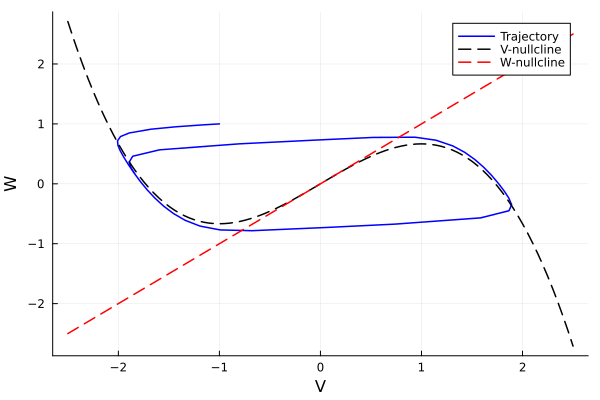

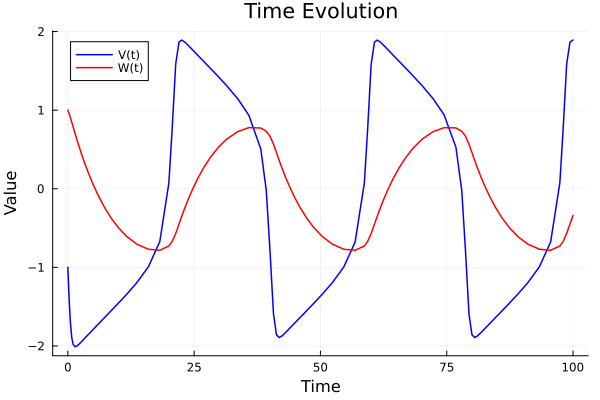

In [14]:
plot_fitzhugh_nagumo(I=-0, eps=0.08, a=0, b=1, factor = 1/3)

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn.gif


Plots.AnimatedGif("/Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn.gif")
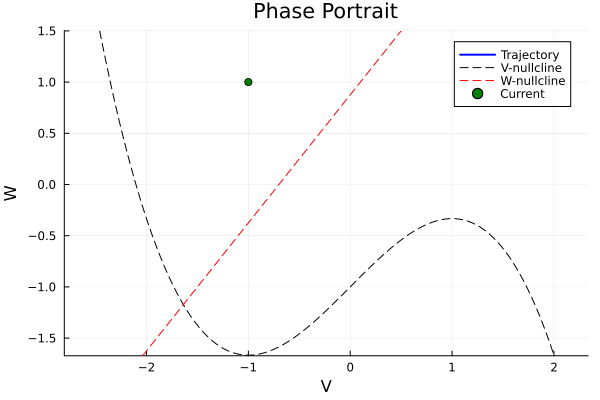

In [15]:
animate_fitzhugh_nagumo_PIR(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3, upper = -0.2, lower = -1, tspan=(0.0, 500.0))


[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn.gif


Plots.AnimatedGif("/Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn.gif")
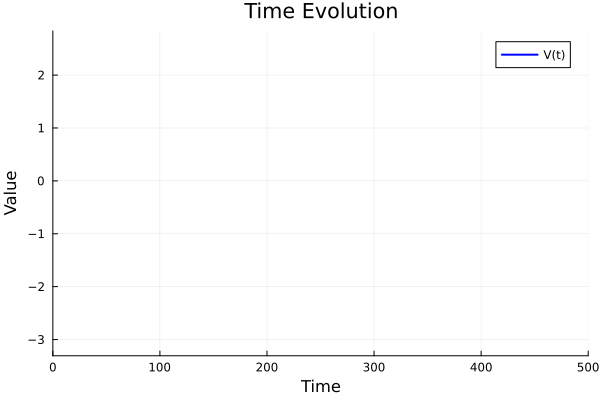

In [16]:
animate_fitzhugh_nagumo_PIR(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3, upper = -0.2, lower = -1, tspan=(0.0, 500.0), mode=:time)


torus_ideal()

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_elliptical_3d_2d.gif


Animation("/var/folders/cf/1x9t06_x17n8bjmdtctgtp280000gp/T/jl_4R9gn2", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000235.png", "000236.png", "000237.png", "000238.png", "000239.png", "000240.png", "000241.png", "000242.png", "000243.png", "000244.png"])

Animation("/var/folders/cf/1x9t06_x17n8bjmdtctgtp280000gp/T/jl_67dRmV", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000235.png", "000236.png", "000237.png", "000238.png", "000239.png", "000240.png", "000241.png", "000242.png", "000243.png", "000244.png"])

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_elliptical_3d.gif


Plots.AnimatedGif("/Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_elliptical_3d.gif")
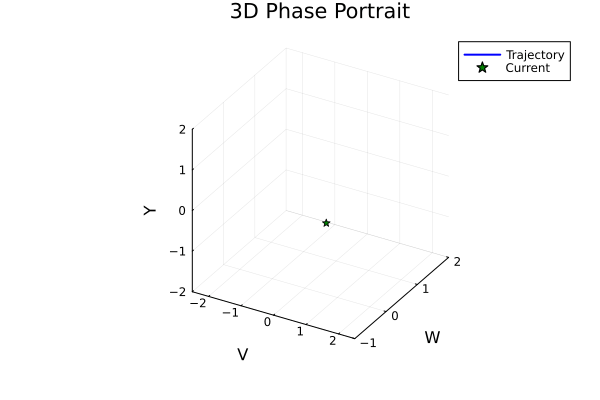

In [17]:
elliptical_burster( I=0.6, eps=0.08, a=0.75, b=0.8, c = -0.56, d = 1, delta = 0.03, mu = 0.03, factor=1/3,
tspan=(0.0, 300.0), u0=[0.93, -0.28, 0.0017])

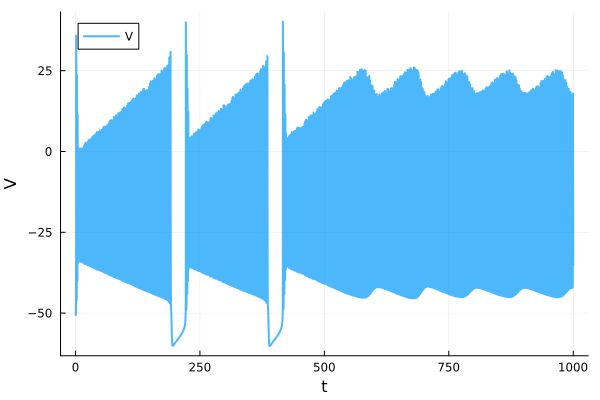

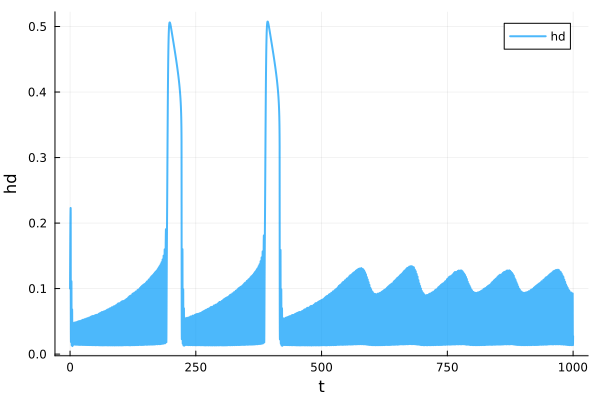

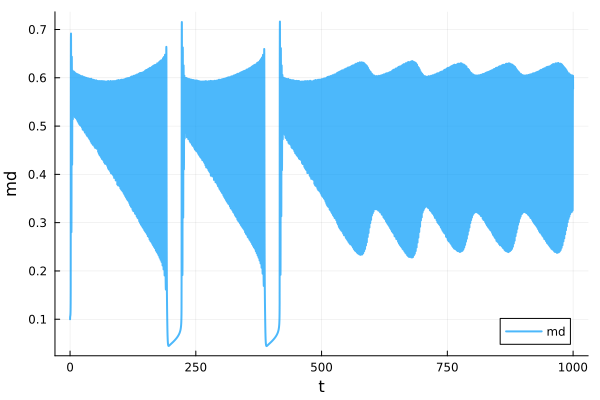

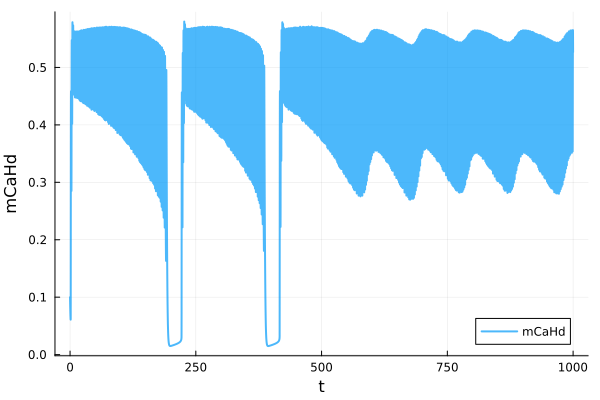

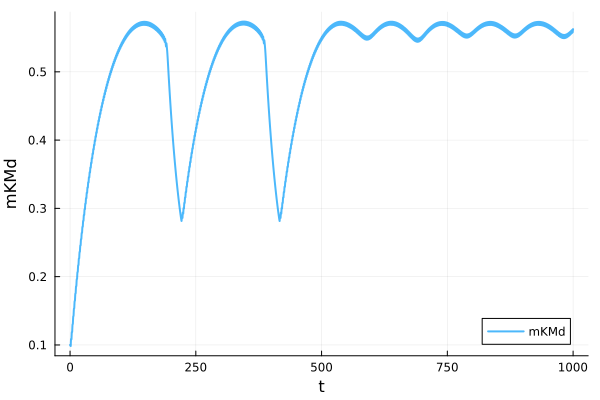

In [19]:
animate_torus( J=-29.75, shift=1, tspan=(0.0, 1000.0), I=0.3125, delta=0.08, mu=0.0002, y0=0.035, hump=-7e-05, width=0.0001)


[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_gap.gif


Plots.AnimatedGif("/Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_gap.gif")
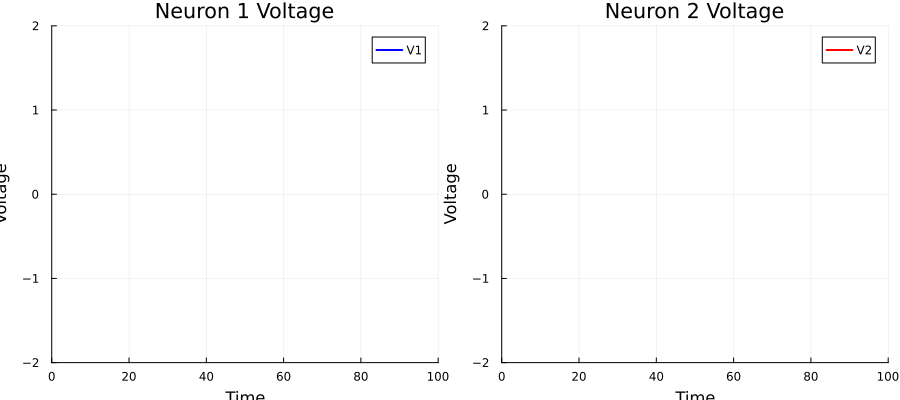

In [20]:
fhn_gap_animation(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3, ggap= 0.1, mode=:voltage)

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_gap.gif


Plots.AnimatedGif("/Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_gap.gif")
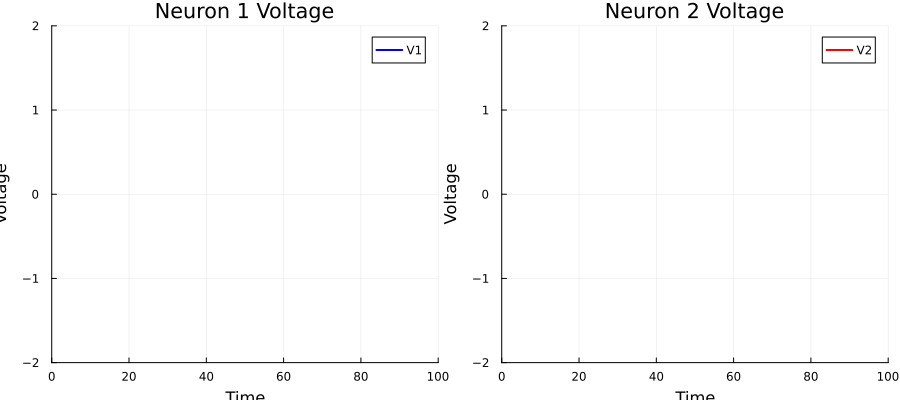

In [21]:
fhn_gap_animation(; I=0.5, eps=0.08, a=0.7, b=0.8, factor=1/3, ggap= 0.9, mode=:voltage)

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_FTM.gif


Plots.AnimatedGif("/Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_FTM.gif")
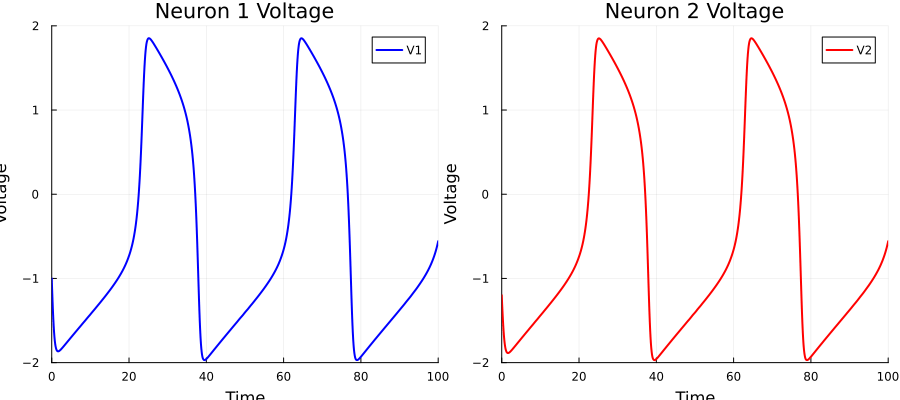

In [22]:
animate_ftm( I = t -> 0.5 ,  # I is now a function of time
eps = 0.02, a = 0.7, b = 0.8, factor = 1/3,
sigmoid_strength= 0.1,
tspan = (0.0, 500.0), u0 = [-1.0, 1.0],
mode = :voltage, save_as = "fhn_FTM.gif", every = 2)

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_FTM_2.gif


Plots.AnimatedGif("/Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/fhn_FTM_2.gif")
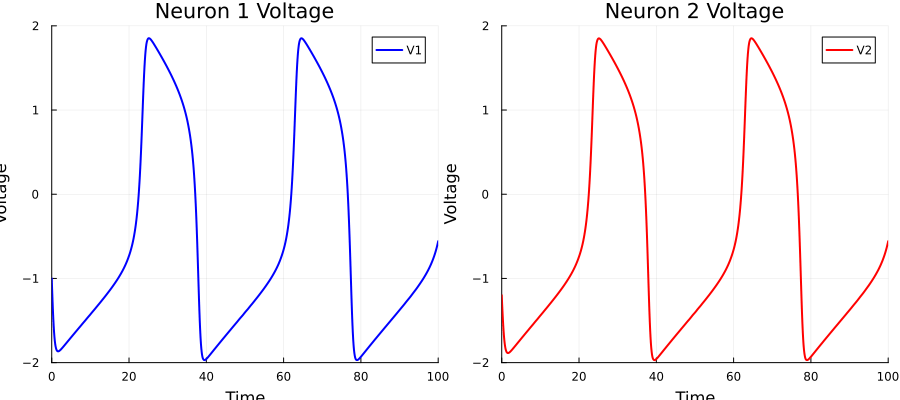

In [23]:
animate_ftm( I = t -> 0.5 ,  # I is now a function of time
eps = 0.02, a = 0.7, b = 0.8, factor = 1/3,
sigmoid_strength= 0.1,
tspan = (0.0, 100.0), u0 = [-1.0, 1.0],
mode = :voltage, save_as = "fhn_FTM_2.gif", every = 2)

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/plateau_bursting_3d_2d.gif


Animation("/var/folders/cf/1x9t06_x17n8bjmdtctgtp280000gp/T/jl_9DvkJM", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "003283.png", "003284.png", "003285.png", "003286.png", "003287.png", "003288.png", "003289.png", "003290.png", "003291.png", "003292.png"])

Animation("/var/folders/cf/1x9t06_x17n8bjmdtctgtp280000gp/T/jl_tPNgik", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "003283.png", "003284.png", "003285.png", "003286.png", "003287.png", "003288.png", "003289.png", "003290.png", "003291.png", "003292.png"])

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/plateau_bursting_3d.gif


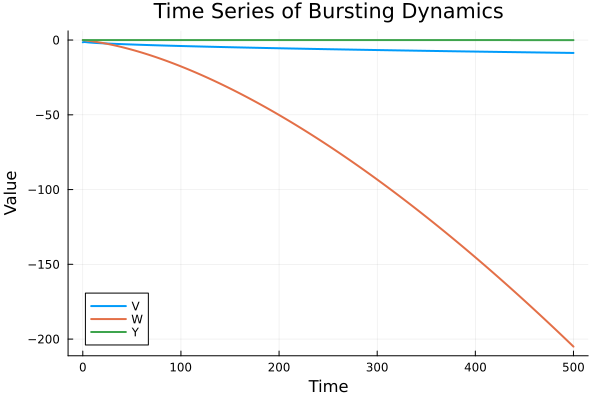

In [31]:
elliptical_burster_2(
    I=0.7,         # enough to excite
    a=0.7,         # recovery offset
    b=0.8,         # sigmoid strength
    c=-0.56,       # unused, safe to keep
    d=0.5,         # make sigmoid steeper
    delta=0.08,    # speed of W
    mu=1e-5,       # slow modulation by Y
    u0=[-1.5, 0.0, 0.001],
    tspan=(0.0, 500.0),
    save_as="plateau_bursting_3d.gif"
)

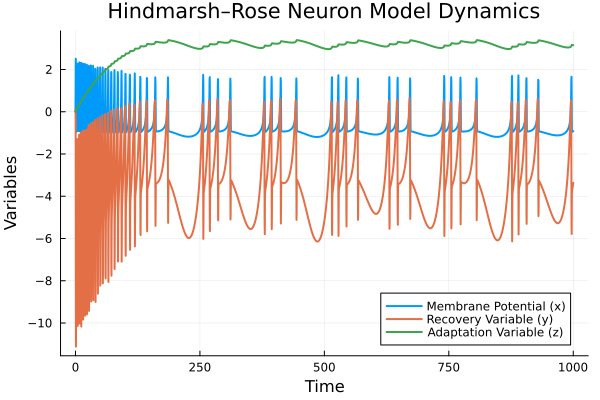

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 2892-element Vector{Float64}:
    0.0
    0.1
    0.16480143401345784
    0.25743093859306077
    0.3437422104516586
    0.45912002202398505
    0.579536609175187
    0.7048104984276702
    0.852560130955591
    1.0048789734905141
    1.1901167195927362
    1.3665173520010336
    1.4815572022161319
    ⋮
  997.0614613838536
  997.2435765172924
  997.414670800499
  997.5607110301484
  997.7498382023816
  997.9487549301356
  998.2079830040005
  998.5212442924775
  998.9226098448812
  999.3731090636162
  999.8197090193596
 1000.0
u: 2892-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [0.3394251718917495, 0.07696998950516803, 0.0042384592679221645]
 [0.5903461888753814, 0.06586177831005662, 0.007443219353431469]
 [1.0197945286738301, -0.1417867267291402, 0.012766963336476662]
 [1.5015652966727007, -0.7104054672013284, 0.01867328663440007]
 [2.1487332920856956, -2.392575370332374, 0.028171687163163754]
 [2.507

In [33]:
hindmarsh_rose(
    a=1.0, 
    b=3.0, 
    c=1.0, 
    d=5.0, 
    r=0.006, 
    s=4.0, 
    x_R=-1.6, 
    I=3.25, 
    u0=[0.0, 0.0, 0.0], 
    tspan=(0.0, 1000.0), 
    solver=Tsit5(), 
    dt=0.1, 
    save_plots=true, 
    filename="hindmarsh_rose_plot.png"
)

In [47]:
hindmarsh_rose_animated(
    a=1, 
    b=2.0, 
    c=1, 
    d=4.0, 
    r=0.006, 
    s=4.0, 
    x_R=-1.6, 
    I=3.25, 
    u0=[0.0, 0.0, 0.0], 
    tspan=(0.0, 1500.0), 
    solver=Tsit5(), 
    dt=0.1, 
    save_gif=true, 
    gif_filename="hindmarsh_rose_animation_3.gif", 
    fps=30
)

[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/hindmarsh_rose_animation_3.gif


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 4475-element Vector{Float64}:
    0.0
    0.1
    0.1703556809666975
    0.2761239584975106
    0.3784284945660706
    0.5051952058358067
    0.6313343362489984
    0.7937947453276307
    0.966475014293134
    1.162001477109402
    1.3864786646445473
    1.658354014976922
    2.047091661980801
    ⋮
 1494.2426906701066
 1494.7238137696206
 1495.1973889995534
 1495.6794278840061
 1496.452443731208
 1497.0850404619605
 1497.7330580947582
 1498.2363611738408
 1498.8520125001874
 1499.3333263350848
 1499.8687303458914
 1500.0
u: 4475-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [0.3357126347001225, 0.08080082182227885, 0.004236269258086559]
 [0.5935157773630667, 0.08315769091955075, 0.007716881469463433]
 [1.0190418286717853, -0.09230353509556893, 0.013810392626699221]
 [1.4350209448026785, -0.5836194438960279, 0.02074833938793229]
 [1.821297054075469, -1.6983342585282974, 0.030605609930121597]
 [1.96365636

In [70]:
animate_hh_model(
    C=4.0, 
    gNa=135.0, 
    gK=39.0, 
    gL=0.1, 
    ENa=55.0, 
    EK=-90.0, 
    EL=-65.0, 
    I = t -> (t > 10 && t < 80) ? 25.0 : 0.0,  # Stronger current
    u0 = [-65.0, 0.05, 0.32, 0.6],             # Canonical initial state
    tspan = (0.0, 100.0), 
    save_path = "hh_model_2.gif", 
    fps = 30    
    )

Animation saved to hh_model_2.gif


[ Info: Saved animation to /Users/tommystell/Documents/Documents - Delia’s MacBook Air/GSU_coursework/SP25/DFNS/hh_model_2.gif
